# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

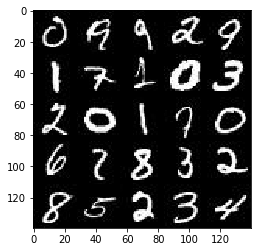

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

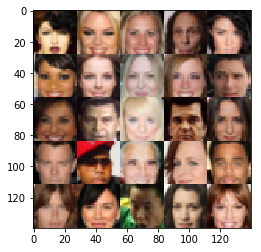

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name= 'input_z')
    learning_rate = tf.placeholder(tf.float32, name ='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha =0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relul_1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d(relul_1, 128, 5, strides=2, padding='same')
        batchNorm_2 = tf.layers.batch_normalization(layer2, training=True)
        relul_2 = tf.maximum(alpha*batchNorm_2, batchNorm_2)
        
        layer3 = tf.layers.conv2d(relul_2, 256, 5, strides=2, padding='same')
        batchNorm_3 = tf.layers.batch_normalization(layer3, training=True)
        relul_3 = tf.maximum(alpha*batchNorm_3, batchNorm_3)
        
        flatten = tf.reshape(relul_3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten,1)
        prediction = tf.sigmoid(logits)

    return prediction, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        layer1 = tf.layers.dense(z, 2*2*512)
        layer1 = tf.reshape(layer1, (-1,2,2,512))
        relul_1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(relul_1, 256, 5, strides=2, padding='valid')
        batchNorm_2 = tf.layers.batch_normalization(layer2, training=True)
        relul_2 = tf.maximum(alpha*batchNorm_2, batchNorm_2)
        
        layer3 = tf.layers.conv2d_transpose(relul_2, 128, 5, strides=2, padding='same')
        batchNorm_3 = tf.layers.batch_normalization(layer3, training=True)
        relul_3 = tf.maximum(alpha*batchNorm_3, batchNorm_3)
        
        logits = tf.layers.conv2d_transpose(relul_3, out_channel_dim, 5, strides=2, padding='same')
        
        
        output= tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_variables = tf.trainable_variables()
    d_vars = [var for var in trainable_variables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainable_variables if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.6447... Generator Loss: 2.2881
Epoch 0/2... Discriminator Loss: 3.0594... Generator Loss: 3.1128
Epoch 0/2... Discriminator Loss: 2.0265... Generator Loss: 3.0696
Epoch 0/2... Discriminator Loss: 1.1285... Generator Loss: 3.2484


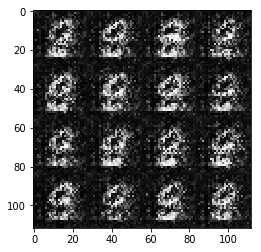

Epoch 0/2... Discriminator Loss: 1.0711... Generator Loss: 3.4970
Epoch 0/2... Discriminator Loss: 1.1000... Generator Loss: 2.9055
Epoch 0/2... Discriminator Loss: 1.1759... Generator Loss: 1.2613
Epoch 0/2... Discriminator Loss: 1.3370... Generator Loss: 1.1487
Epoch 0/2... Discriminator Loss: 1.2534... Generator Loss: 1.1281


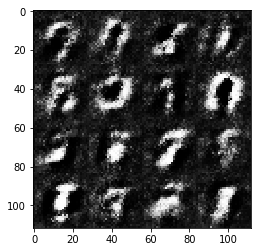

Epoch 0/2... Discriminator Loss: 1.3343... Generator Loss: 1.6047
Epoch 0/2... Discriminator Loss: 1.3357... Generator Loss: 1.3673
Epoch 0/2... Discriminator Loss: 1.4732... Generator Loss: 1.7627
Epoch 0/2... Discriminator Loss: 1.4374... Generator Loss: 1.5016
Epoch 0/2... Discriminator Loss: 1.4541... Generator Loss: 1.4641


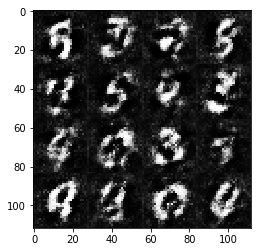

Epoch 0/2... Discriminator Loss: 1.2907... Generator Loss: 1.2201
Epoch 0/2... Discriminator Loss: 1.4385... Generator Loss: 1.3833
Epoch 0/2... Discriminator Loss: 1.2463... Generator Loss: 1.6013
Epoch 0/2... Discriminator Loss: 1.1933... Generator Loss: 1.6325
Epoch 0/2... Discriminator Loss: 1.1757... Generator Loss: 1.6500


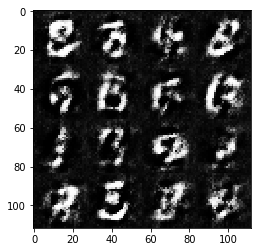

Epoch 0/2... Discriminator Loss: 1.2192... Generator Loss: 1.4426
Epoch 0/2... Discriminator Loss: 1.2149... Generator Loss: 1.6628
Epoch 0/2... Discriminator Loss: 1.0469... Generator Loss: 1.2787
Epoch 0/2... Discriminator Loss: 1.2295... Generator Loss: 1.4502
Epoch 0/2... Discriminator Loss: 1.0657... Generator Loss: 1.3540


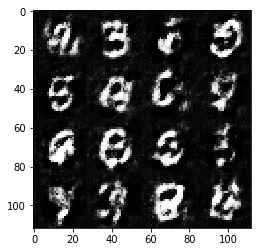

Epoch 0/2... Discriminator Loss: 1.1438... Generator Loss: 1.7257
Epoch 0/2... Discriminator Loss: 1.0762... Generator Loss: 1.4590
Epoch 0/2... Discriminator Loss: 1.1020... Generator Loss: 1.9058
Epoch 0/2... Discriminator Loss: 0.9075... Generator Loss: 1.3337
Epoch 0/2... Discriminator Loss: 1.0411... Generator Loss: 1.6545


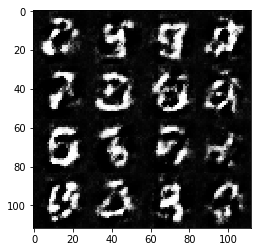

Epoch 0/2... Discriminator Loss: 1.0359... Generator Loss: 1.6683
Epoch 0/2... Discriminator Loss: 1.0742... Generator Loss: 1.4725
Epoch 0/2... Discriminator Loss: 0.9699... Generator Loss: 1.4069
Epoch 0/2... Discriminator Loss: 1.3286... Generator Loss: 1.9065
Epoch 0/2... Discriminator Loss: 1.1004... Generator Loss: 1.8622


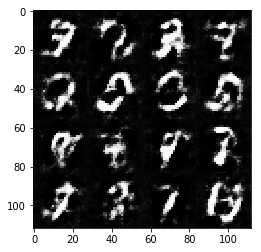

Epoch 0/2... Discriminator Loss: 0.8642... Generator Loss: 1.4238
Epoch 0/2... Discriminator Loss: 1.0272... Generator Loss: 1.4970
Epoch 0/2... Discriminator Loss: 1.1244... Generator Loss: 1.6362
Epoch 0/2... Discriminator Loss: 1.0489... Generator Loss: 1.7363
Epoch 0/2... Discriminator Loss: 0.9010... Generator Loss: 1.5289


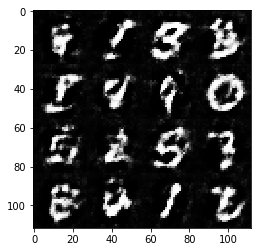

Epoch 0/2... Discriminator Loss: 0.9597... Generator Loss: 1.1333
Epoch 0/2... Discriminator Loss: 1.0733... Generator Loss: 1.5040
Epoch 0/2... Discriminator Loss: 0.9203... Generator Loss: 1.2350
Epoch 0/2... Discriminator Loss: 1.0259... Generator Loss: 1.4950
Epoch 0/2... Discriminator Loss: 1.1422... Generator Loss: 1.3941


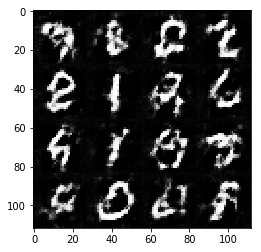

Epoch 0/2... Discriminator Loss: 1.2664... Generator Loss: 1.7592
Epoch 0/2... Discriminator Loss: 1.2526... Generator Loss: 1.7563
Epoch 0/2... Discriminator Loss: 1.3392... Generator Loss: 1.7519
Epoch 0/2... Discriminator Loss: 1.0121... Generator Loss: 1.3489
Epoch 0/2... Discriminator Loss: 1.2505... Generator Loss: 1.6560


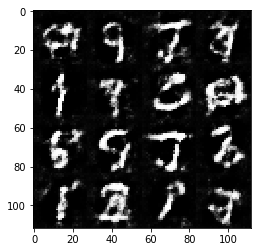

Epoch 0/2... Discriminator Loss: 1.0926... Generator Loss: 1.0921
Epoch 0/2... Discriminator Loss: 1.0552... Generator Loss: 1.5642
Epoch 0/2... Discriminator Loss: 1.0493... Generator Loss: 1.5978
Epoch 0/2... Discriminator Loss: 1.1165... Generator Loss: 1.7692
Epoch 0/2... Discriminator Loss: 1.0881... Generator Loss: 1.5167


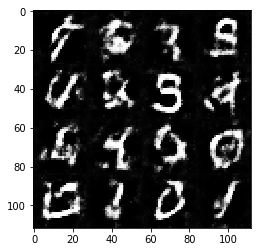

Epoch 0/2... Discriminator Loss: 1.2175... Generator Loss: 1.4853
Epoch 0/2... Discriminator Loss: 1.0129... Generator Loss: 1.1011
Epoch 0/2... Discriminator Loss: 1.3036... Generator Loss: 1.7737
Epoch 0/2... Discriminator Loss: 0.9868... Generator Loss: 1.2188
Epoch 0/2... Discriminator Loss: 1.1725... Generator Loss: 1.1554


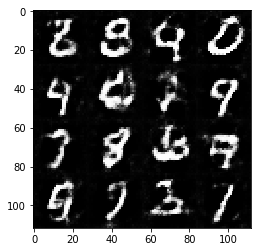

Epoch 0/2... Discriminator Loss: 1.2237... Generator Loss: 1.7493
Epoch 0/2... Discriminator Loss: 1.0057... Generator Loss: 1.3323
Epoch 0/2... Discriminator Loss: 1.0755... Generator Loss: 1.2631
Epoch 0/2... Discriminator Loss: 1.0501... Generator Loss: 1.4817
Epoch 0/2... Discriminator Loss: 0.9752... Generator Loss: 1.3919


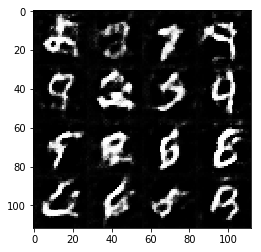

Epoch 0/2... Discriminator Loss: 1.0357... Generator Loss: 1.4706
Epoch 0/2... Discriminator Loss: 0.9732... Generator Loss: 1.2474
Epoch 0/2... Discriminator Loss: 1.0230... Generator Loss: 1.1198
Epoch 0/2... Discriminator Loss: 1.2637... Generator Loss: 1.3362
Epoch 0/2... Discriminator Loss: 0.9982... Generator Loss: 1.2374


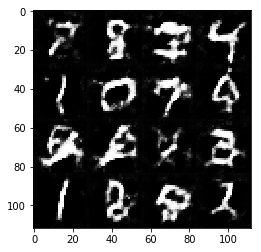

Epoch 0/2... Discriminator Loss: 1.0679... Generator Loss: 1.5798
Epoch 0/2... Discriminator Loss: 1.1290... Generator Loss: 1.3147
Epoch 0/2... Discriminator Loss: 1.0851... Generator Loss: 0.6333
Epoch 0/2... Discriminator Loss: 1.1908... Generator Loss: 0.4927
Epoch 0/2... Discriminator Loss: 1.4455... Generator Loss: 0.3440


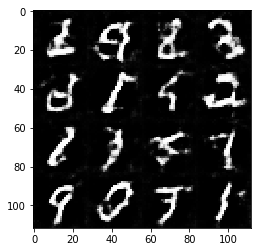

Epoch 0/2... Discriminator Loss: 1.3060... Generator Loss: 0.4156
Epoch 0/2... Discriminator Loss: 1.2174... Generator Loss: 0.4938
Epoch 0/2... Discriminator Loss: 0.9596... Generator Loss: 1.1191
Epoch 0/2... Discriminator Loss: 1.0417... Generator Loss: 1.2581
Epoch 0/2... Discriminator Loss: 0.8815... Generator Loss: 1.3550


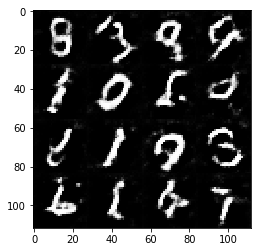

Epoch 0/2... Discriminator Loss: 1.1716... Generator Loss: 1.3060
Epoch 0/2... Discriminator Loss: 0.9707... Generator Loss: 1.6727
Epoch 0/2... Discriminator Loss: 0.9688... Generator Loss: 1.3610
Epoch 0/2... Discriminator Loss: 1.1518... Generator Loss: 1.4780
Epoch 0/2... Discriminator Loss: 1.1393... Generator Loss: 0.5763


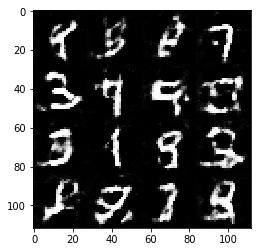

Epoch 0/2... Discriminator Loss: 1.0445... Generator Loss: 0.6521
Epoch 0/2... Discriminator Loss: 1.3177... Generator Loss: 0.4214
Epoch 0/2... Discriminator Loss: 1.1445... Generator Loss: 0.5025
Epoch 0/2... Discriminator Loss: 1.0166... Generator Loss: 0.6690
Epoch 0/2... Discriminator Loss: 0.9729... Generator Loss: 1.0037


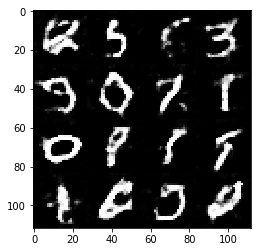

Epoch 0/2... Discriminator Loss: 1.0398... Generator Loss: 1.4336
Epoch 0/2... Discriminator Loss: 1.1578... Generator Loss: 1.5625
Epoch 0/2... Discriminator Loss: 1.0225... Generator Loss: 0.6118
Epoch 0/2... Discriminator Loss: 1.4072... Generator Loss: 0.3501
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.3955


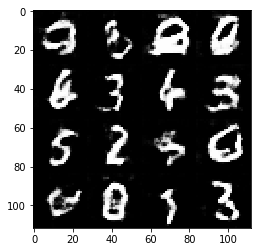

Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.4716
Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 0.8200... Generator Loss: 1.2074
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.1770


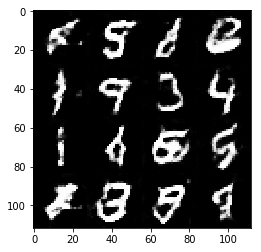

Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.2921
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 0.9121


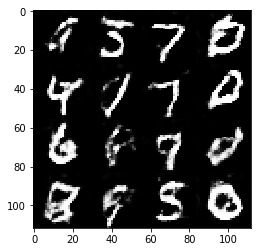

Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.3815
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.3684
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.3317


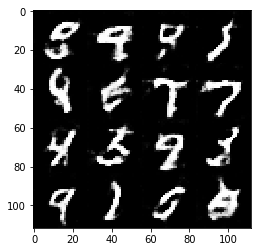

Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 1.3197
Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 2.7161
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 0.6836


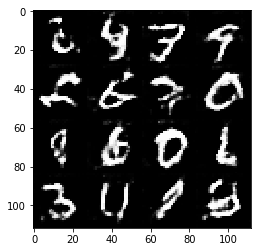

Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 2.2856
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 0.7534


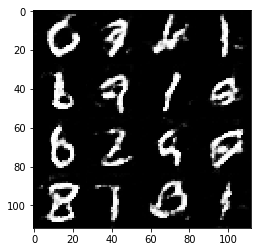

Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.5729
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 0.8036


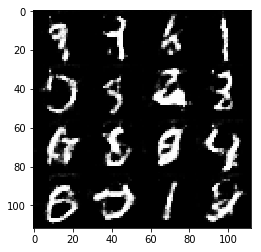

Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 0.8776
Epoch 1/2... Discriminator Loss: 1.5858... Generator Loss: 0.2953
Epoch 1/2... Discriminator Loss: 2.1457... Generator Loss: 0.1528
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 0.6890


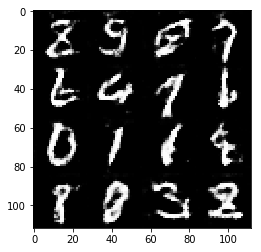

Epoch 1/2... Discriminator Loss: 0.8388... Generator Loss: 1.7497
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 1.3632
Epoch 1/2... Discriminator Loss: 0.8838... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 1.2322


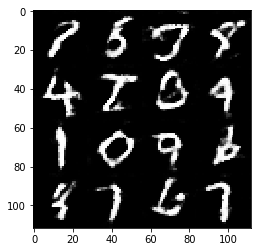

Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.9600
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.9612
Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 0.6930... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 0.7820


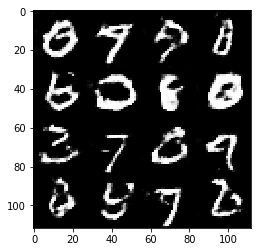

Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 3.3378... Generator Loss: 4.7441
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 0.7498


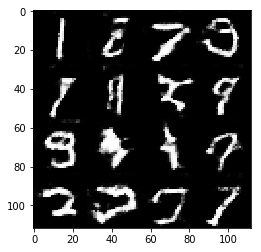

Epoch 1/2... Discriminator Loss: 1.9719... Generator Loss: 0.2256
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 0.6083... Generator Loss: 1.2372
Epoch 1/2... Discriminator Loss: 1.7132... Generator Loss: 2.9079
Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 0.8197


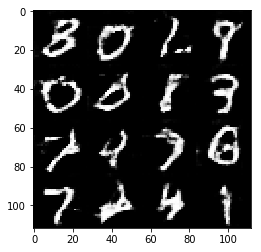

Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.2218
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.5506


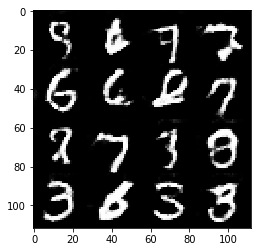

Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.8967


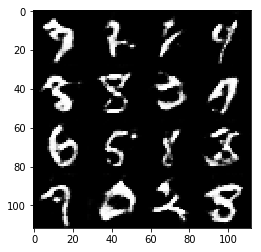

Epoch 1/2... Discriminator Loss: 0.9394... Generator Loss: 1.8336
Epoch 1/2... Discriminator Loss: 0.7747... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.3796
Epoch 1/2... Discriminator Loss: 1.6500... Generator Loss: 2.5343
Epoch 1/2... Discriminator Loss: 0.7293... Generator Loss: 1.0176


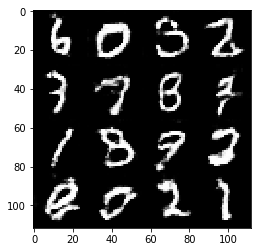

Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 0.6225... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.3923


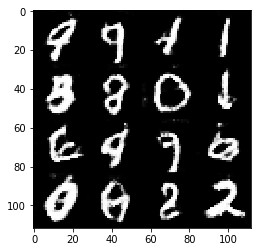

Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 1.3402
Epoch 1/2... Discriminator Loss: 1.7782... Generator Loss: 0.2515
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 1.3282


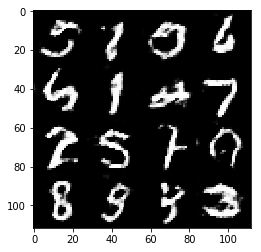

Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 2.5243... Generator Loss: 0.1129
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 0.6982... Generator Loss: 1.4080


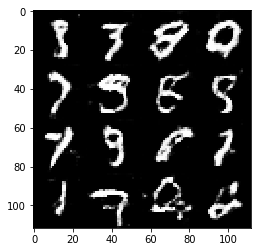

Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 1.3313
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 1.9870
Epoch 1/2... Discriminator Loss: 2.6664... Generator Loss: 4.4201


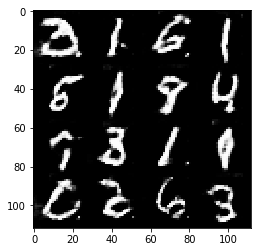

Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 0.9191


In [26]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/2... Discriminator Loss: 2.2494... Generator Loss: 0.1389
Epoch 0/2... Discriminator Loss: 0.4228... Generator Loss: 12.1667
Epoch 0/2... Discriminator Loss: 0.4042... Generator Loss: 17.9429
Epoch 0/2... Discriminator Loss: 0.0717... Generator Loss: 5.0388


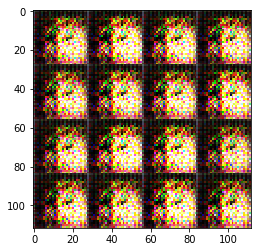

Epoch 0/2... Discriminator Loss: 0.2832... Generator Loss: 5.4930
Epoch 0/2... Discriminator Loss: 0.7752... Generator Loss: 9.4503
Epoch 0/2... Discriminator Loss: 1.0912... Generator Loss: 0.5948
Epoch 0/2... Discriminator Loss: 0.3076... Generator Loss: 2.3728
Epoch 0/2... Discriminator Loss: 0.4821... Generator Loss: 2.9113


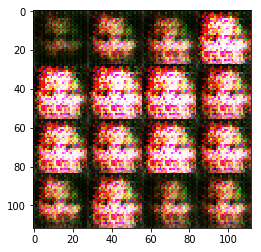

Epoch 0/2... Discriminator Loss: 0.5534... Generator Loss: 1.4166
Epoch 0/2... Discriminator Loss: 0.8493... Generator Loss: 0.9284
Epoch 0/2... Discriminator Loss: 0.5266... Generator Loss: 1.2189
Epoch 0/2... Discriminator Loss: 0.5315... Generator Loss: 5.1258
Epoch 0/2... Discriminator Loss: 0.3733... Generator Loss: 2.3307


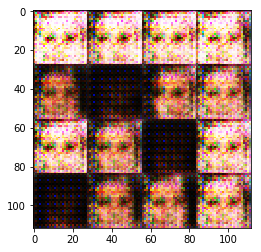

Epoch 0/2... Discriminator Loss: 0.2649... Generator Loss: 3.6611
Epoch 0/2... Discriminator Loss: 0.4619... Generator Loss: 5.5032
Epoch 0/2... Discriminator Loss: 0.1926... Generator Loss: 3.5075
Epoch 0/2... Discriminator Loss: 0.4574... Generator Loss: 2.8962
Epoch 0/2... Discriminator Loss: 1.3598... Generator Loss: 5.7857


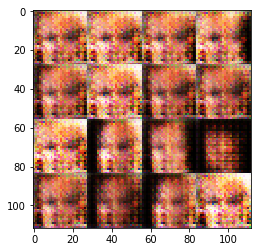

Epoch 0/2... Discriminator Loss: 0.8017... Generator Loss: 1.4534
Epoch 0/2... Discriminator Loss: 0.8724... Generator Loss: 2.0244
Epoch 0/2... Discriminator Loss: 1.7256... Generator Loss: 0.3866
Epoch 0/2... Discriminator Loss: 1.2898... Generator Loss: 0.7539
Epoch 0/2... Discriminator Loss: 1.2920... Generator Loss: 0.8542


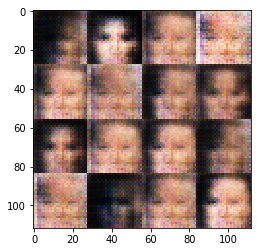

Epoch 0/2... Discriminator Loss: 1.1593... Generator Loss: 1.4388
Epoch 0/2... Discriminator Loss: 1.3421... Generator Loss: 0.4578
Epoch 0/2... Discriminator Loss: 1.0617... Generator Loss: 0.8257
Epoch 0/2... Discriminator Loss: 0.6402... Generator Loss: 1.6295
Epoch 0/2... Discriminator Loss: 0.9959... Generator Loss: 0.8622


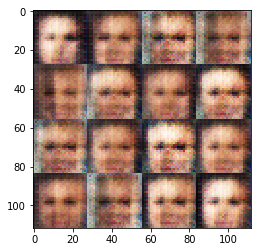

Epoch 0/2... Discriminator Loss: 1.1733... Generator Loss: 0.7649
Epoch 0/2... Discriminator Loss: 0.7146... Generator Loss: 1.2430
Epoch 0/2... Discriminator Loss: 1.5953... Generator Loss: 0.4970
Epoch 0/2... Discriminator Loss: 1.0879... Generator Loss: 0.9746
Epoch 0/2... Discriminator Loss: 0.8228... Generator Loss: 1.4123


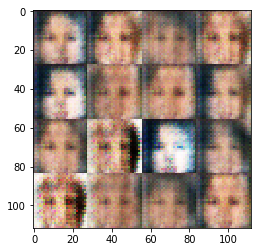

Epoch 0/2... Discriminator Loss: 0.9972... Generator Loss: 1.1366
Epoch 0/2... Discriminator Loss: 1.2824... Generator Loss: 0.6932
Epoch 0/2... Discriminator Loss: 1.3831... Generator Loss: 1.6561
Epoch 0/2... Discriminator Loss: 1.1670... Generator Loss: 0.6994
Epoch 0/2... Discriminator Loss: 0.9008... Generator Loss: 1.2331


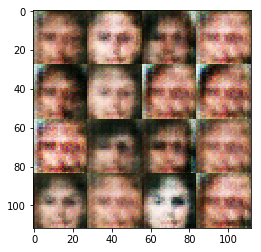

Epoch 0/2... Discriminator Loss: 0.6854... Generator Loss: 1.4906
Epoch 0/2... Discriminator Loss: 0.8012... Generator Loss: 1.0769
Epoch 0/2... Discriminator Loss: 0.7061... Generator Loss: 2.0286
Epoch 0/2... Discriminator Loss: 1.1103... Generator Loss: 0.7563
Epoch 0/2... Discriminator Loss: 0.9141... Generator Loss: 0.9521


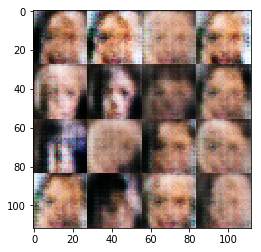

Epoch 0/2... Discriminator Loss: 1.3072... Generator Loss: 1.7876
Epoch 0/2... Discriminator Loss: 1.3500... Generator Loss: 0.6750
Epoch 0/2... Discriminator Loss: 1.2699... Generator Loss: 1.5060
Epoch 0/2... Discriminator Loss: 0.9596... Generator Loss: 1.0822
Epoch 0/2... Discriminator Loss: 0.9707... Generator Loss: 1.1706


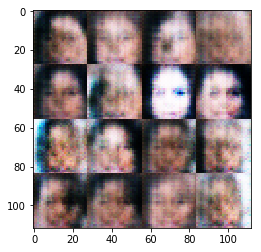

Epoch 0/2... Discriminator Loss: 1.0893... Generator Loss: 1.4772
Epoch 0/2... Discriminator Loss: 1.3970... Generator Loss: 2.0165
Epoch 0/2... Discriminator Loss: 1.1138... Generator Loss: 1.1860
Epoch 0/2... Discriminator Loss: 1.0424... Generator Loss: 1.2830
Epoch 0/2... Discriminator Loss: 0.5400... Generator Loss: 1.9048


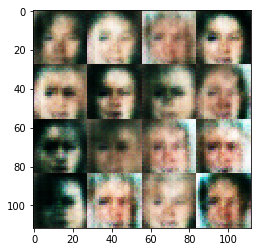

Epoch 0/2... Discriminator Loss: 1.0618... Generator Loss: 0.6695
Epoch 0/2... Discriminator Loss: 0.8631... Generator Loss: 1.3788
Epoch 0/2... Discriminator Loss: 0.8864... Generator Loss: 0.8743
Epoch 0/2... Discriminator Loss: 1.0668... Generator Loss: 1.4764
Epoch 0/2... Discriminator Loss: 0.6787... Generator Loss: 1.1995


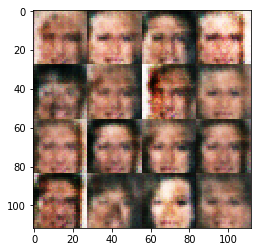

Epoch 0/2... Discriminator Loss: 1.0358... Generator Loss: 1.2510
Epoch 0/2... Discriminator Loss: 0.8776... Generator Loss: 1.3329
Epoch 0/2... Discriminator Loss: 0.8146... Generator Loss: 1.4279
Epoch 0/2... Discriminator Loss: 0.8313... Generator Loss: 1.2035
Epoch 0/2... Discriminator Loss: 1.5704... Generator Loss: 3.1083


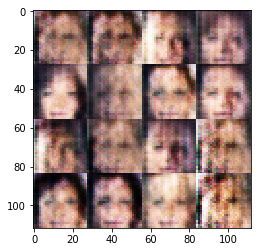

Epoch 0/2... Discriminator Loss: 0.8771... Generator Loss: 1.4165
Epoch 0/2... Discriminator Loss: 1.0686... Generator Loss: 0.9491
Epoch 0/2... Discriminator Loss: 0.8408... Generator Loss: 1.1092
Epoch 0/2... Discriminator Loss: 0.9008... Generator Loss: 1.4641
Epoch 0/2... Discriminator Loss: 0.9733... Generator Loss: 2.0517


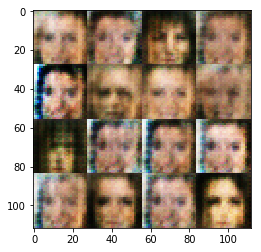

Epoch 0/2... Discriminator Loss: 1.2578... Generator Loss: 1.7485
Epoch 0/2... Discriminator Loss: 1.0566... Generator Loss: 0.6495
Epoch 0/2... Discriminator Loss: 1.0769... Generator Loss: 2.2351
Epoch 0/2... Discriminator Loss: 1.0584... Generator Loss: 0.8308
Epoch 0/2... Discriminator Loss: 0.8437... Generator Loss: 1.0416


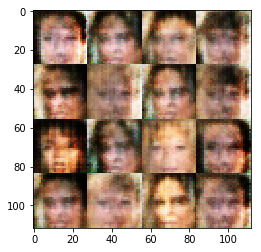

Epoch 0/2... Discriminator Loss: 1.2440... Generator Loss: 0.4936
Epoch 0/2... Discriminator Loss: 1.0862... Generator Loss: 1.1474
Epoch 0/2... Discriminator Loss: 0.8941... Generator Loss: 1.0667
Epoch 0/2... Discriminator Loss: 1.0137... Generator Loss: 2.5878
Epoch 0/2... Discriminator Loss: 1.2519... Generator Loss: 0.8756


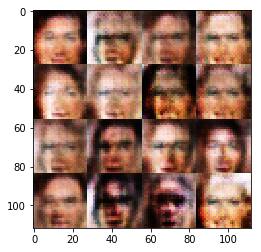

Epoch 0/2... Discriminator Loss: 0.8594... Generator Loss: 1.2915
Epoch 0/2... Discriminator Loss: 0.9628... Generator Loss: 1.3825
Epoch 0/2... Discriminator Loss: 0.8429... Generator Loss: 1.0919
Epoch 0/2... Discriminator Loss: 1.0403... Generator Loss: 0.6813
Epoch 0/2... Discriminator Loss: 1.0504... Generator Loss: 0.6434


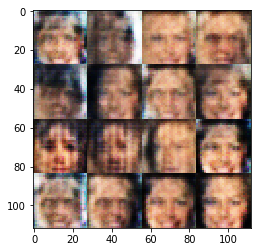

Epoch 0/2... Discriminator Loss: 1.0232... Generator Loss: 1.1698
Epoch 0/2... Discriminator Loss: 0.9229... Generator Loss: 1.6979
Epoch 0/2... Discriminator Loss: 0.8989... Generator Loss: 1.1750
Epoch 0/2... Discriminator Loss: 0.9437... Generator Loss: 1.0858
Epoch 0/2... Discriminator Loss: 0.9089... Generator Loss: 1.5675


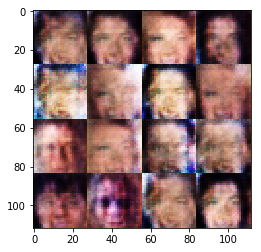

Epoch 0/2... Discriminator Loss: 0.7872... Generator Loss: 1.5585
Epoch 0/2... Discriminator Loss: 0.9167... Generator Loss: 0.9265
Epoch 0/2... Discriminator Loss: 1.4534... Generator Loss: 0.3803
Epoch 0/2... Discriminator Loss: 0.9138... Generator Loss: 1.2441
Epoch 0/2... Discriminator Loss: 0.7835... Generator Loss: 1.1605


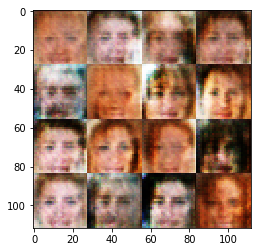

Epoch 0/2... Discriminator Loss: 0.7002... Generator Loss: 1.0819
Epoch 0/2... Discriminator Loss: 1.3001... Generator Loss: 0.5430
Epoch 0/2... Discriminator Loss: 0.9651... Generator Loss: 1.5712
Epoch 0/2... Discriminator Loss: 1.8455... Generator Loss: 0.2406
Epoch 0/2... Discriminator Loss: 0.8963... Generator Loss: 0.9427


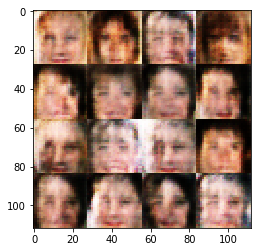

Epoch 0/2... Discriminator Loss: 1.1148... Generator Loss: 1.9231
Epoch 0/2... Discriminator Loss: 1.0915... Generator Loss: 0.9701
Epoch 0/2... Discriminator Loss: 0.8536... Generator Loss: 2.0860
Epoch 0/2... Discriminator Loss: 1.0060... Generator Loss: 1.3974
Epoch 0/2... Discriminator Loss: 0.8307... Generator Loss: 1.5292


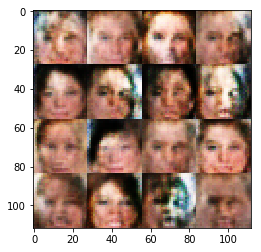

Epoch 0/2... Discriminator Loss: 0.9934... Generator Loss: 0.7332
Epoch 0/2... Discriminator Loss: 0.8324... Generator Loss: 1.3412
Epoch 0/2... Discriminator Loss: 0.9904... Generator Loss: 0.8480
Epoch 0/2... Discriminator Loss: 1.0342... Generator Loss: 1.2769
Epoch 0/2... Discriminator Loss: 0.9249... Generator Loss: 1.0936


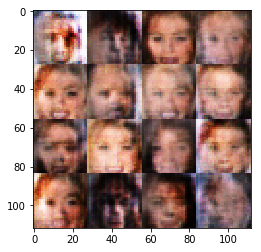

Epoch 0/2... Discriminator Loss: 0.9266... Generator Loss: 1.4557
Epoch 0/2... Discriminator Loss: 1.2221... Generator Loss: 0.5766
Epoch 0/2... Discriminator Loss: 1.2293... Generator Loss: 0.5581
Epoch 0/2... Discriminator Loss: 0.9646... Generator Loss: 0.7269
Epoch 0/2... Discriminator Loss: 0.9113... Generator Loss: 1.0364


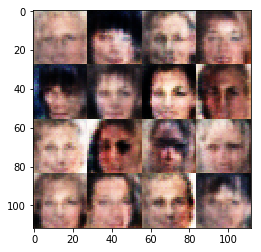

Epoch 0/2... Discriminator Loss: 0.8128... Generator Loss: 1.1869
Epoch 0/2... Discriminator Loss: 0.9844... Generator Loss: 1.3184
Epoch 0/2... Discriminator Loss: 0.8967... Generator Loss: 1.6143
Epoch 0/2... Discriminator Loss: 1.0521... Generator Loss: 0.7709
Epoch 0/2... Discriminator Loss: 1.2030... Generator Loss: 1.8219


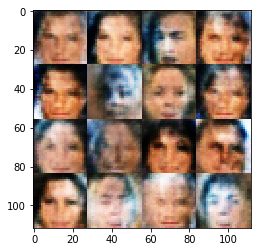

Epoch 0/2... Discriminator Loss: 0.7845... Generator Loss: 1.1018
Epoch 0/2... Discriminator Loss: 1.0801... Generator Loss: 0.7497
Epoch 0/2... Discriminator Loss: 0.8544... Generator Loss: 1.2213
Epoch 0/2... Discriminator Loss: 1.0083... Generator Loss: 0.8935
Epoch 0/2... Discriminator Loss: 1.3236... Generator Loss: 0.4794


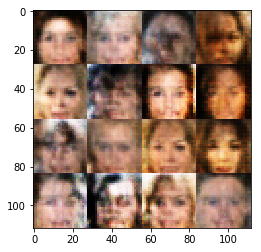

Epoch 0/2... Discriminator Loss: 0.8078... Generator Loss: 1.7573
Epoch 0/2... Discriminator Loss: 0.9596... Generator Loss: 1.1528
Epoch 0/2... Discriminator Loss: 1.0705... Generator Loss: 1.1264
Epoch 0/2... Discriminator Loss: 0.9111... Generator Loss: 1.0897
Epoch 0/2... Discriminator Loss: 1.1243... Generator Loss: 0.6001


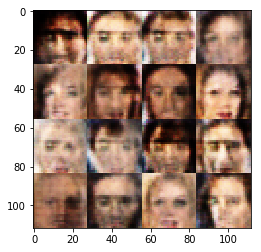

Epoch 0/2... Discriminator Loss: 1.1245... Generator Loss: 0.8444
Epoch 0/2... Discriminator Loss: 0.8959... Generator Loss: 1.0776
Epoch 0/2... Discriminator Loss: 0.7562... Generator Loss: 1.2099
Epoch 0/2... Discriminator Loss: 1.0221... Generator Loss: 0.9803
Epoch 0/2... Discriminator Loss: 1.0508... Generator Loss: 1.1938


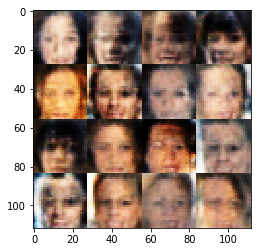

Epoch 0/2... Discriminator Loss: 0.9878... Generator Loss: 1.4523
Epoch 0/2... Discriminator Loss: 0.9828... Generator Loss: 1.1720
Epoch 0/2... Discriminator Loss: 0.8551... Generator Loss: 1.0598
Epoch 0/2... Discriminator Loss: 0.9894... Generator Loss: 1.2954
Epoch 0/2... Discriminator Loss: 1.0531... Generator Loss: 0.9073


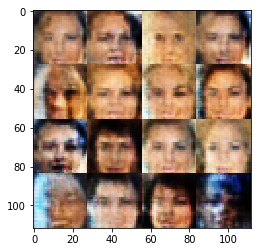

Epoch 0/2... Discriminator Loss: 0.9295... Generator Loss: 1.0274
Epoch 0/2... Discriminator Loss: 1.1506... Generator Loss: 0.5339
Epoch 0/2... Discriminator Loss: 0.9997... Generator Loss: 2.0535
Epoch 0/2... Discriminator Loss: 0.8827... Generator Loss: 1.0176
Epoch 0/2... Discriminator Loss: 0.8248... Generator Loss: 0.9406


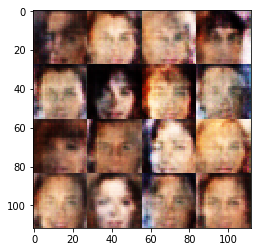

Epoch 0/2... Discriminator Loss: 0.9072... Generator Loss: 0.8811
Epoch 0/2... Discriminator Loss: 1.2095... Generator Loss: 0.5677
Epoch 0/2... Discriminator Loss: 0.9741... Generator Loss: 0.8641
Epoch 0/2... Discriminator Loss: 0.8325... Generator Loss: 1.5462
Epoch 0/2... Discriminator Loss: 0.8539... Generator Loss: 1.5115


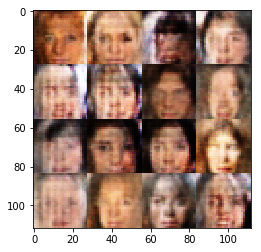

Epoch 0/2... Discriminator Loss: 1.0425... Generator Loss: 0.8205
Epoch 0/2... Discriminator Loss: 1.0813... Generator Loss: 2.0706
Epoch 0/2... Discriminator Loss: 0.9628... Generator Loss: 0.9343
Epoch 0/2... Discriminator Loss: 1.1085... Generator Loss: 1.2494
Epoch 0/2... Discriminator Loss: 0.9686... Generator Loss: 1.3738


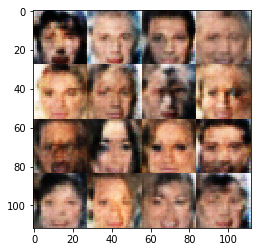

Epoch 0/2... Discriminator Loss: 1.1831... Generator Loss: 1.3419
Epoch 0/2... Discriminator Loss: 0.8577... Generator Loss: 1.1196
Epoch 0/2... Discriminator Loss: 1.2829... Generator Loss: 0.5228
Epoch 0/2... Discriminator Loss: 0.9598... Generator Loss: 0.8220
Epoch 0/2... Discriminator Loss: 1.0266... Generator Loss: 1.6627


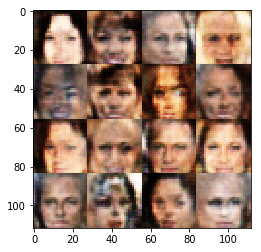

Epoch 0/2... Discriminator Loss: 1.0830... Generator Loss: 2.0338
Epoch 0/2... Discriminator Loss: 1.2857... Generator Loss: 1.2477
Epoch 0/2... Discriminator Loss: 0.8473... Generator Loss: 1.2881
Epoch 0/2... Discriminator Loss: 0.8859... Generator Loss: 1.1314
Epoch 0/2... Discriminator Loss: 0.9152... Generator Loss: 0.8178


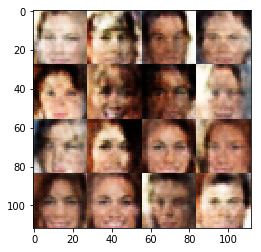

Epoch 0/2... Discriminator Loss: 1.0034... Generator Loss: 0.8162
Epoch 0/2... Discriminator Loss: 1.0948... Generator Loss: 1.3222
Epoch 0/2... Discriminator Loss: 0.8770... Generator Loss: 1.6188
Epoch 0/2... Discriminator Loss: 0.9387... Generator Loss: 1.4420
Epoch 0/2... Discriminator Loss: 0.9447... Generator Loss: 1.2049


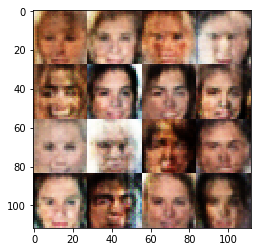

Epoch 0/2... Discriminator Loss: 1.1813... Generator Loss: 0.5672
Epoch 0/2... Discriminator Loss: 1.6046... Generator Loss: 0.2990
Epoch 0/2... Discriminator Loss: 1.0069... Generator Loss: 0.7831
Epoch 0/2... Discriminator Loss: 0.7777... Generator Loss: 1.1889
Epoch 0/2... Discriminator Loss: 0.7635... Generator Loss: 1.5814


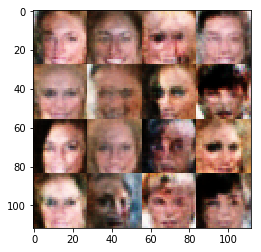

Epoch 0/2... Discriminator Loss: 1.0739... Generator Loss: 0.6319
Epoch 0/2... Discriminator Loss: 0.9746... Generator Loss: 1.4203
Epoch 0/2... Discriminator Loss: 1.6184... Generator Loss: 0.3278
Epoch 0/2... Discriminator Loss: 0.8894... Generator Loss: 0.9090
Epoch 0/2... Discriminator Loss: 0.9066... Generator Loss: 1.2622


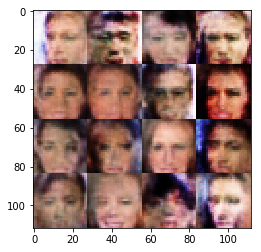

Epoch 0/2... Discriminator Loss: 1.4805... Generator Loss: 0.3509
Epoch 0/2... Discriminator Loss: 1.0798... Generator Loss: 0.6805
Epoch 0/2... Discriminator Loss: 0.9335... Generator Loss: 1.0362
Epoch 0/2... Discriminator Loss: 1.1113... Generator Loss: 2.1689
Epoch 0/2... Discriminator Loss: 1.0754... Generator Loss: 0.6120


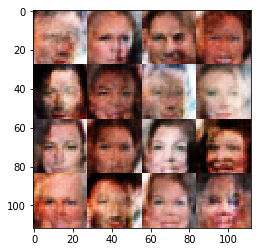

Epoch 0/2... Discriminator Loss: 0.9656... Generator Loss: 1.4443
Epoch 0/2... Discriminator Loss: 1.0709... Generator Loss: 2.4165
Epoch 0/2... Discriminator Loss: 1.1370... Generator Loss: 0.6241
Epoch 0/2... Discriminator Loss: 0.9568... Generator Loss: 0.7598
Epoch 0/2... Discriminator Loss: 0.8654... Generator Loss: 1.2599


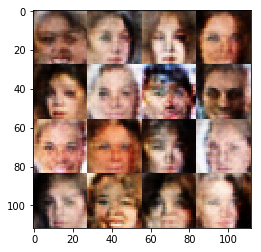

Epoch 0/2... Discriminator Loss: 0.8174... Generator Loss: 2.0138
Epoch 0/2... Discriminator Loss: 0.7733... Generator Loss: 1.3158
Epoch 0/2... Discriminator Loss: 0.8575... Generator Loss: 1.3336
Epoch 0/2... Discriminator Loss: 1.1527... Generator Loss: 0.5842
Epoch 0/2... Discriminator Loss: 1.0854... Generator Loss: 1.8662


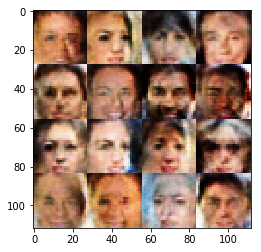

Epoch 0/2... Discriminator Loss: 1.0630... Generator Loss: 0.9149
Epoch 0/2... Discriminator Loss: 0.8518... Generator Loss: 1.2554
Epoch 0/2... Discriminator Loss: 0.9543... Generator Loss: 1.7461
Epoch 0/2... Discriminator Loss: 0.8353... Generator Loss: 1.3044
Epoch 0/2... Discriminator Loss: 1.0179... Generator Loss: 0.8360


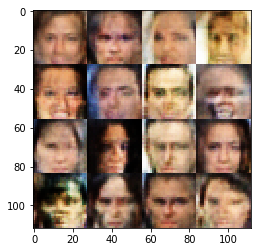

Epoch 0/2... Discriminator Loss: 1.2454... Generator Loss: 0.4794
Epoch 0/2... Discriminator Loss: 0.8837... Generator Loss: 0.9522
Epoch 0/2... Discriminator Loss: 1.2414... Generator Loss: 2.5345
Epoch 0/2... Discriminator Loss: 0.9435... Generator Loss: 0.9453
Epoch 0/2... Discriminator Loss: 1.2319... Generator Loss: 1.8176


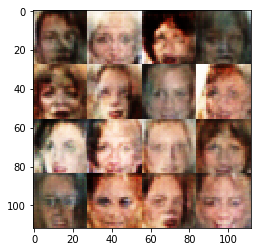

Epoch 0/2... Discriminator Loss: 1.0246... Generator Loss: 1.0866
Epoch 0/2... Discriminator Loss: 1.0323... Generator Loss: 1.5556
Epoch 0/2... Discriminator Loss: 0.8885... Generator Loss: 0.9896
Epoch 0/2... Discriminator Loss: 0.8987... Generator Loss: 1.9310
Epoch 0/2... Discriminator Loss: 1.1102... Generator Loss: 0.8190


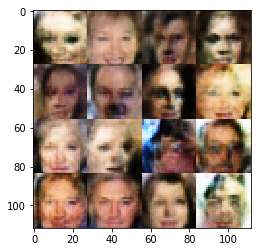

Epoch 0/2... Discriminator Loss: 1.0284... Generator Loss: 0.7036
Epoch 0/2... Discriminator Loss: 1.2606... Generator Loss: 0.5335
Epoch 0/2... Discriminator Loss: 0.9235... Generator Loss: 0.7805
Epoch 0/2... Discriminator Loss: 0.8406... Generator Loss: 1.5070
Epoch 0/2... Discriminator Loss: 0.9703... Generator Loss: 1.6566


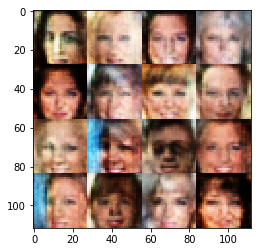

Epoch 0/2... Discriminator Loss: 1.2451... Generator Loss: 0.5634
Epoch 0/2... Discriminator Loss: 1.6688... Generator Loss: 0.3068
Epoch 0/2... Discriminator Loss: 0.8792... Generator Loss: 1.2351
Epoch 0/2... Discriminator Loss: 0.9663... Generator Loss: 1.0420
Epoch 0/2... Discriminator Loss: 0.9247... Generator Loss: 0.9837


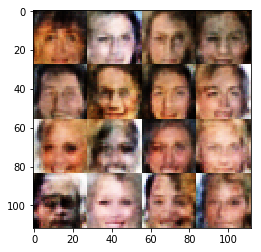

Epoch 0/2... Discriminator Loss: 1.0578... Generator Loss: 2.2534
Epoch 0/2... Discriminator Loss: 1.1705... Generator Loss: 1.2521
Epoch 0/2... Discriminator Loss: 1.2855... Generator Loss: 0.5396
Epoch 0/2... Discriminator Loss: 1.1689... Generator Loss: 0.7877
Epoch 0/2... Discriminator Loss: 1.1232... Generator Loss: 1.2461


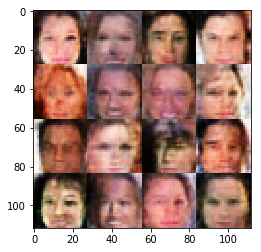

Epoch 0/2... Discriminator Loss: 1.1022... Generator Loss: 1.0366
Epoch 0/2... Discriminator Loss: 1.4458... Generator Loss: 0.4001
Epoch 0/2... Discriminator Loss: 1.0228... Generator Loss: 1.0994
Epoch 0/2... Discriminator Loss: 0.7652... Generator Loss: 1.2668
Epoch 0/2... Discriminator Loss: 1.1327... Generator Loss: 1.5852


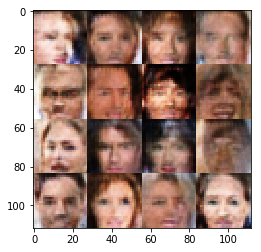

Epoch 0/2... Discriminator Loss: 0.9179... Generator Loss: 0.8178
Epoch 0/2... Discriminator Loss: 0.7697... Generator Loss: 1.1137
Epoch 0/2... Discriminator Loss: 1.0101... Generator Loss: 0.6861
Epoch 0/2... Discriminator Loss: 0.7910... Generator Loss: 1.2489
Epoch 0/2... Discriminator Loss: 1.5839... Generator Loss: 3.3115


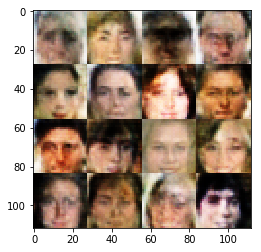

Epoch 0/2... Discriminator Loss: 0.9106... Generator Loss: 0.8949
Epoch 0/2... Discriminator Loss: 0.8973... Generator Loss: 1.5476
Epoch 0/2... Discriminator Loss: 1.1786... Generator Loss: 0.5223
Epoch 0/2... Discriminator Loss: 1.4691... Generator Loss: 0.3841
Epoch 0/2... Discriminator Loss: 1.2768... Generator Loss: 0.5548


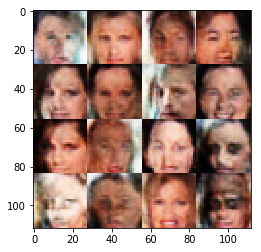

Epoch 0/2... Discriminator Loss: 0.9171... Generator Loss: 0.8118
Epoch 0/2... Discriminator Loss: 0.9756... Generator Loss: 0.7466
Epoch 0/2... Discriminator Loss: 0.9152... Generator Loss: 0.8024
Epoch 0/2... Discriminator Loss: 1.5103... Generator Loss: 0.3480
Epoch 0/2... Discriminator Loss: 0.8791... Generator Loss: 1.0077


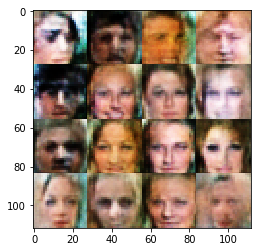

Epoch 0/2... Discriminator Loss: 0.8792... Generator Loss: 1.0914
Epoch 0/2... Discriminator Loss: 1.3004... Generator Loss: 0.4484
Epoch 0/2... Discriminator Loss: 1.3043... Generator Loss: 2.0516
Epoch 0/2... Discriminator Loss: 1.1531... Generator Loss: 0.5889
Epoch 0/2... Discriminator Loss: 0.9349... Generator Loss: 1.7634


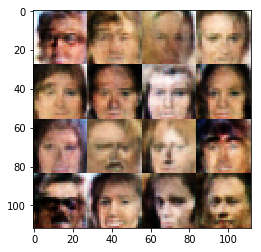

Epoch 0/2... Discriminator Loss: 0.7233... Generator Loss: 1.5232
Epoch 0/2... Discriminator Loss: 0.7461... Generator Loss: 1.0662
Epoch 0/2... Discriminator Loss: 0.9227... Generator Loss: 1.8369
Epoch 0/2... Discriminator Loss: 1.0714... Generator Loss: 0.5556
Epoch 0/2... Discriminator Loss: 0.7486... Generator Loss: 1.2688


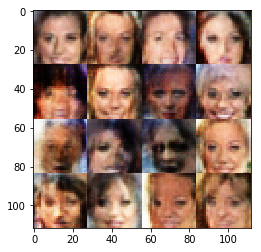

Epoch 0/2... Discriminator Loss: 0.8945... Generator Loss: 2.4666
Epoch 0/2... Discriminator Loss: 1.1155... Generator Loss: 0.6364
Epoch 0/2... Discriminator Loss: 1.3405... Generator Loss: 0.4573
Epoch 0/2... Discriminator Loss: 1.0038... Generator Loss: 0.7957
Epoch 0/2... Discriminator Loss: 1.1485... Generator Loss: 0.5742


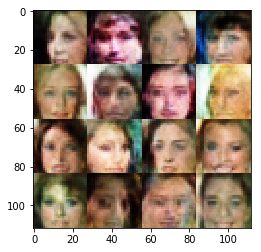

Epoch 0/2... Discriminator Loss: 0.9283... Generator Loss: 0.8246
Epoch 0/2... Discriminator Loss: 1.5508... Generator Loss: 0.3218
Epoch 0/2... Discriminator Loss: 1.0049... Generator Loss: 0.7342
Epoch 0/2... Discriminator Loss: 1.2898... Generator Loss: 0.4986
Epoch 0/2... Discriminator Loss: 0.8339... Generator Loss: 1.0541


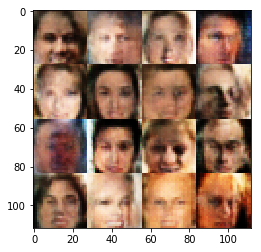

Epoch 0/2... Discriminator Loss: 1.1883... Generator Loss: 1.8785
Epoch 0/2... Discriminator Loss: 1.0156... Generator Loss: 1.0017
Epoch 0/2... Discriminator Loss: 0.8907... Generator Loss: 1.3610
Epoch 0/2... Discriminator Loss: 0.9749... Generator Loss: 0.7302
Epoch 0/2... Discriminator Loss: 0.9566... Generator Loss: 1.1768


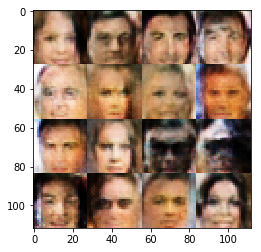

Epoch 0/2... Discriminator Loss: 1.0411... Generator Loss: 2.7195
Epoch 0/2... Discriminator Loss: 1.2596... Generator Loss: 0.5354
Epoch 0/2... Discriminator Loss: 0.8388... Generator Loss: 1.2279
Epoch 0/2... Discriminator Loss: 0.9685... Generator Loss: 1.7014
Epoch 0/2... Discriminator Loss: 0.7517... Generator Loss: 1.2963


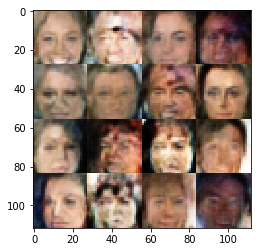

Epoch 0/2... Discriminator Loss: 1.0040... Generator Loss: 1.2202
Epoch 0/2... Discriminator Loss: 0.9745... Generator Loss: 0.6996
Epoch 0/2... Discriminator Loss: 0.9968... Generator Loss: 0.7641
Epoch 0/2... Discriminator Loss: 1.2884... Generator Loss: 0.4599
Epoch 0/2... Discriminator Loss: 0.7292... Generator Loss: 1.3608


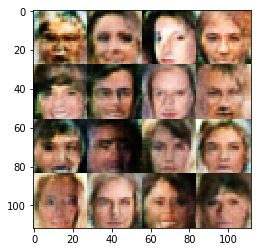

Epoch 0/2... Discriminator Loss: 1.4379... Generator Loss: 0.3266
Epoch 0/2... Discriminator Loss: 0.9907... Generator Loss: 0.7499
Epoch 0/2... Discriminator Loss: 0.9292... Generator Loss: 1.0200
Epoch 0/2... Discriminator Loss: 0.9277... Generator Loss: 2.1542
Epoch 0/2... Discriminator Loss: 0.7742... Generator Loss: 0.9847


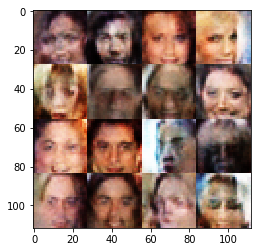

Epoch 0/2... Discriminator Loss: 0.7031... Generator Loss: 1.2437
Epoch 0/2... Discriminator Loss: 0.8465... Generator Loss: 0.9408
Epoch 0/2... Discriminator Loss: 0.7586... Generator Loss: 1.5964
Epoch 0/2... Discriminator Loss: 0.5514... Generator Loss: 1.8542
Epoch 0/2... Discriminator Loss: 0.8036... Generator Loss: 1.5839


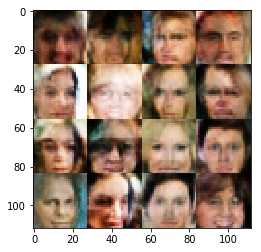

Epoch 0/2... Discriminator Loss: 0.9166... Generator Loss: 0.7880
Epoch 0/2... Discriminator Loss: 0.9732... Generator Loss: 0.8481
Epoch 0/2... Discriminator Loss: 0.9949... Generator Loss: 0.9034
Epoch 0/2... Discriminator Loss: 1.0894... Generator Loss: 0.7702
Epoch 0/2... Discriminator Loss: 1.0202... Generator Loss: 1.9634


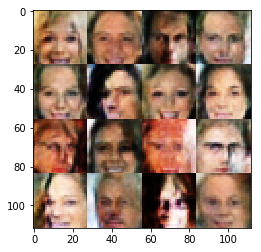

Epoch 0/2... Discriminator Loss: 0.8392... Generator Loss: 0.9787
Epoch 0/2... Discriminator Loss: 1.0339... Generator Loss: 1.1805
Epoch 0/2... Discriminator Loss: 0.8223... Generator Loss: 1.2994
Epoch 0/2... Discriminator Loss: 1.1783... Generator Loss: 0.5396
Epoch 0/2... Discriminator Loss: 1.3065... Generator Loss: 0.4632


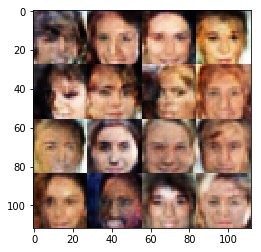

Epoch 0/2... Discriminator Loss: 0.9709... Generator Loss: 1.1671
Epoch 0/2... Discriminator Loss: 1.0657... Generator Loss: 0.9449
Epoch 0/2... Discriminator Loss: 1.4633... Generator Loss: 2.1290
Epoch 0/2... Discriminator Loss: 1.3984... Generator Loss: 0.3963
Epoch 0/2... Discriminator Loss: 0.9547... Generator Loss: 0.7765


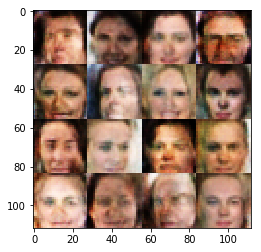

Epoch 0/2... Discriminator Loss: 0.8801... Generator Loss: 1.9743
Epoch 0/2... Discriminator Loss: 0.9221... Generator Loss: 0.9336
Epoch 0/2... Discriminator Loss: 1.1450... Generator Loss: 2.2203
Epoch 0/2... Discriminator Loss: 1.5522... Generator Loss: 2.0858
Epoch 0/2... Discriminator Loss: 1.5029... Generator Loss: 0.4200


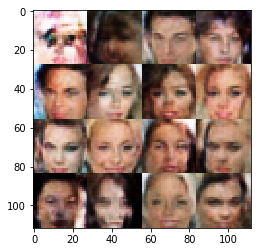

Epoch 0/2... Discriminator Loss: 0.9492... Generator Loss: 1.0526
Epoch 0/2... Discriminator Loss: 0.8814... Generator Loss: 1.0933
Epoch 0/2... Discriminator Loss: 0.8964... Generator Loss: 0.8082
Epoch 0/2... Discriminator Loss: 1.0230... Generator Loss: 0.6063
Epoch 0/2... Discriminator Loss: 1.1022... Generator Loss: 0.7480


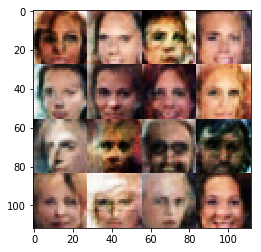

Epoch 0/2... Discriminator Loss: 1.0404... Generator Loss: 0.7081
Epoch 0/2... Discriminator Loss: 0.9655... Generator Loss: 1.4173
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.2618
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 1.9831
Epoch 1/2... Discriminator Loss: 1.6966... Generator Loss: 0.3639


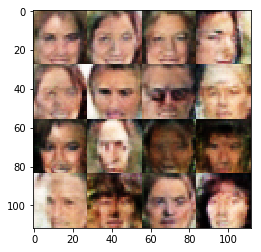

Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.8545


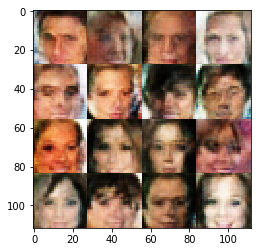

Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 1.8209
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.6548
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 1.3875
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 1.0736


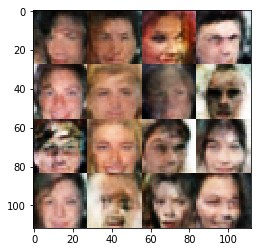

Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 1.6577
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.6248


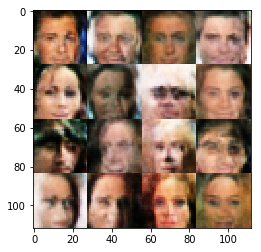

Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.4299


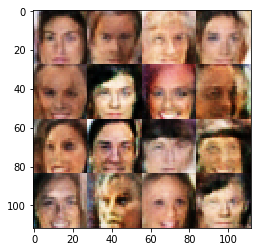

Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 1.9176
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 0.9902
Epoch 1/2... Discriminator Loss: 2.0042... Generator Loss: 2.2886
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.0093


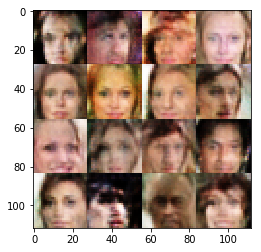

Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.0010
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 1.8770
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.5875


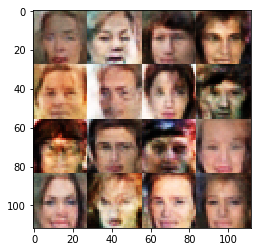

Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.2335
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.4072


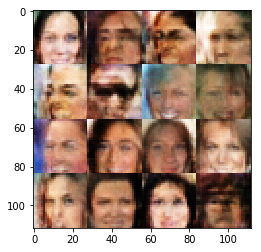

Epoch 1/2... Discriminator Loss: 1.7395... Generator Loss: 0.2834
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 2.1326
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.7126


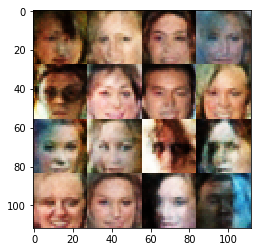

Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 2.2928
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 0.7319
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.5702


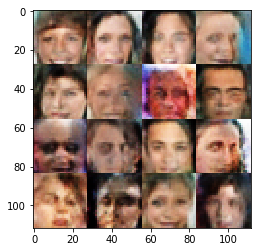

Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.0683
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.7785


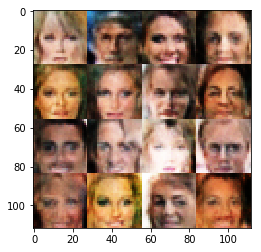

Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 1.5011
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 0.9598... Generator Loss: 0.9419


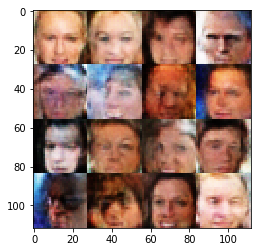

Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.9866


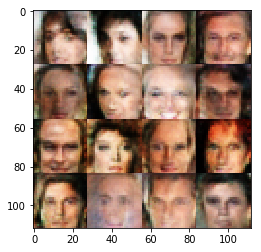

Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 1.4694


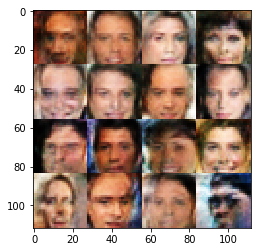

Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 1.2481
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.5289
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.1444


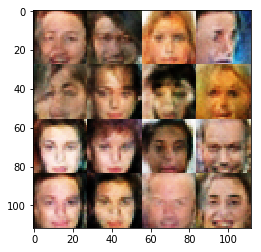

Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.2235
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.3430
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.4868


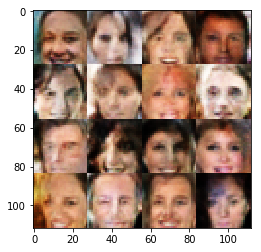

Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.2059
Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.6669


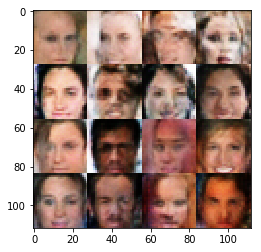

Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 1.3059
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.6387
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.7993... Generator Loss: 1.7590


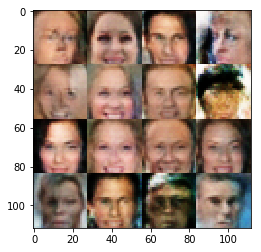

Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 0.8736
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.6012
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 0.8340


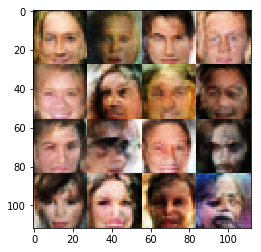

Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 1.8386
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.9944


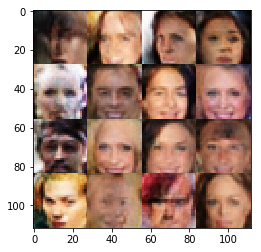

Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 0.9335... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 1.4958
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.7086


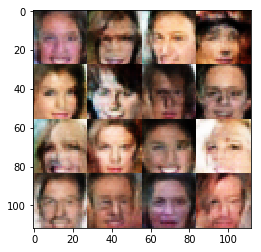

Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.4492
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.9083


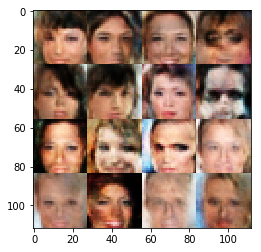

Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.5545
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 0.8880... Generator Loss: 1.1969


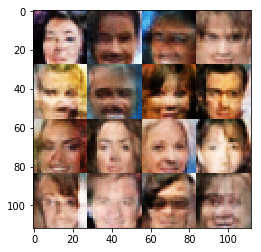

Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.5617


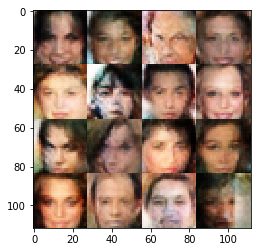

Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.1890
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.4604


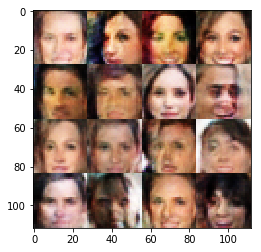

Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 0.7673


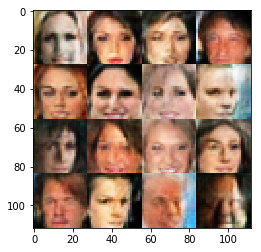

Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 1.5554
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 2.2091
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 1.1153


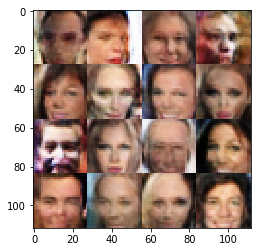

Epoch 1/2... Discriminator Loss: 0.6917... Generator Loss: 2.2551
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.6274
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 2.0149
Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 1.1747


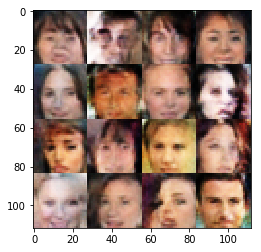

Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 1.8764
Epoch 1/2... Discriminator Loss: 1.5038... Generator Loss: 0.3306
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.3061
Epoch 1/2... Discriminator Loss: 0.8413... Generator Loss: 1.4068
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.0135


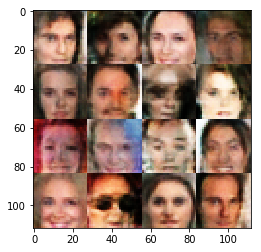

Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 1.4373
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.7444
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 0.5721


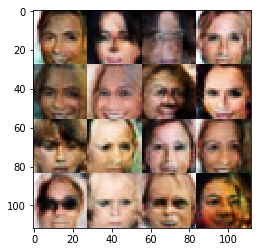

Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 1.1901
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 1.0507
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 1.5068
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.7811


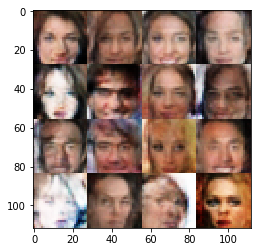

Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.9063
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 1.4164
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.6277


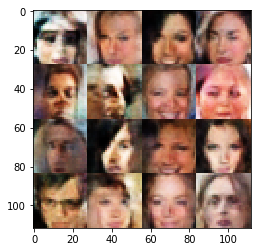

Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.9442
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 1.3590


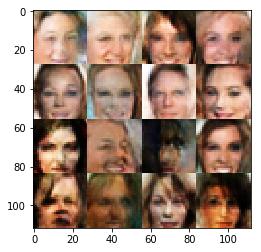

Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.4377
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 0.9830


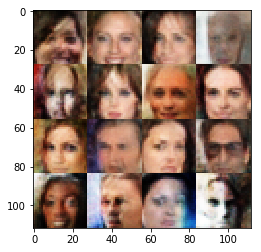

Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 2.1110
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 1.5467


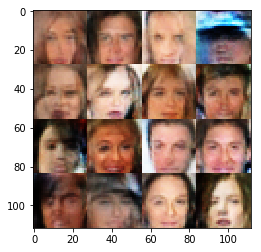

Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.4602
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.4509


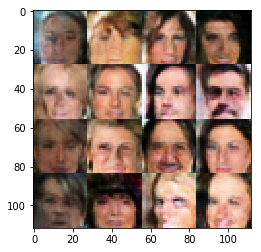

Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.5713
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 1.4154
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.7648... Generator Loss: 0.2629


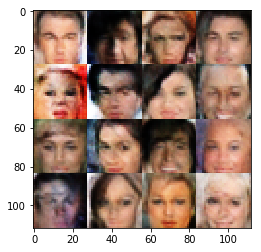

Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 2.3367
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.7804


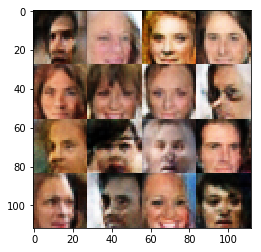

Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 0.9231


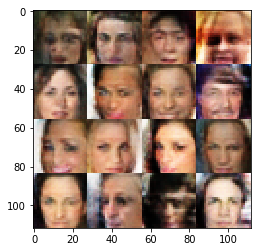

Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.3982
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 1.1079... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 1.0265


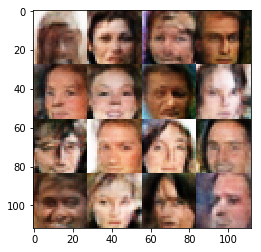

Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.8858
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 1.4295
Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 0.9424


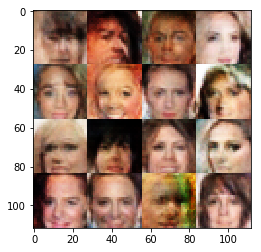

Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.6769
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.8898


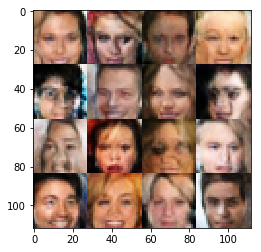

Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.9551
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.5325
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.5711


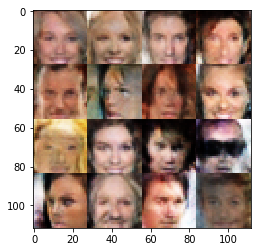

Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 0.6735
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.4575
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.9255
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.4992
Epoch 1/2... Discriminator Loss: 0.7951... Generator Loss: 0.9322


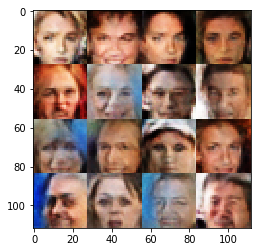

Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 0.7116... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.3782


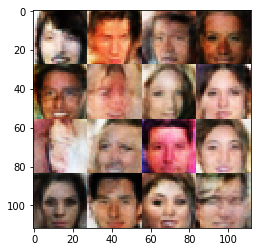

Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 1.3865
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 0.9010


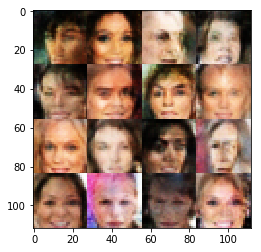

Epoch 1/2... Discriminator Loss: 1.5800... Generator Loss: 1.8482
Epoch 1/2... Discriminator Loss: 0.6069... Generator Loss: 1.7443
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 2.0497
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 0.6762


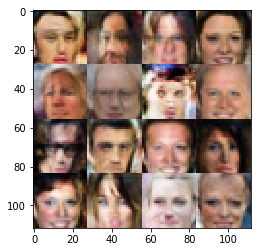

Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 1.7356
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 0.9806


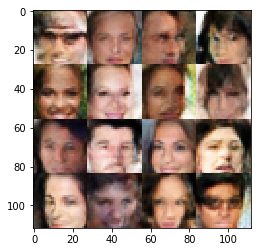

Epoch 1/2... Discriminator Loss: 0.8653... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 1.3116


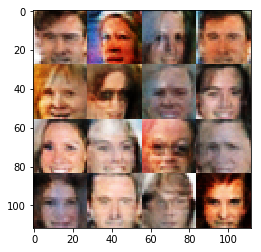

Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.6242
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 1.4127
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.3572
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 0.8469


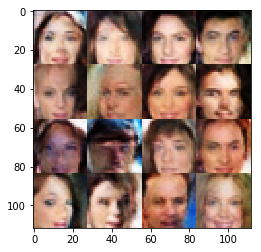

Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.2904
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 2.0219
Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.0299


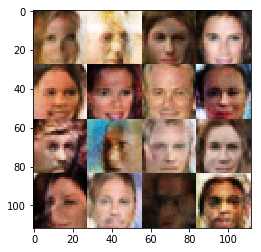

Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.5395... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 0.9558


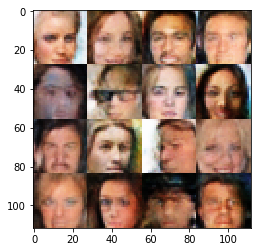

Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.5100
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.6457


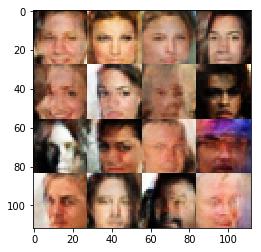

Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 0.8329


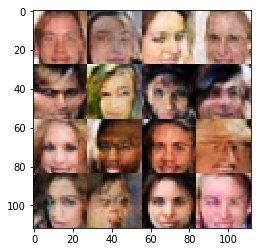

Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 0.7634... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.1239


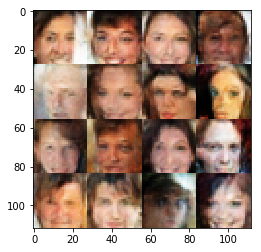

Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.3599
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 2.0204
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.7835


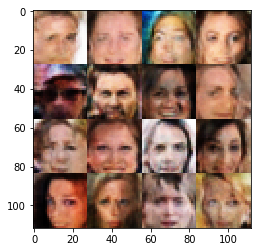

Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.7437


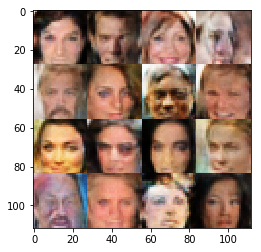

Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 2.0784... Generator Loss: 0.1831
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 2.2832


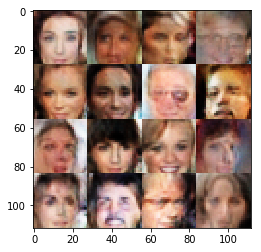

Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.3923
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 0.8936
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 1.1697


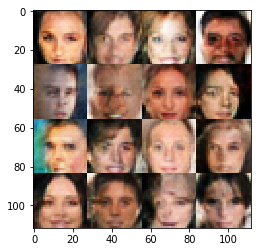

Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 1.4160
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.5703


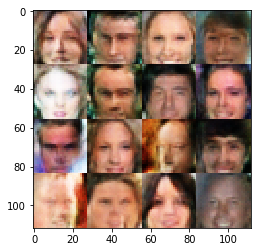

Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.5815
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 2.1008... Generator Loss: 2.6954


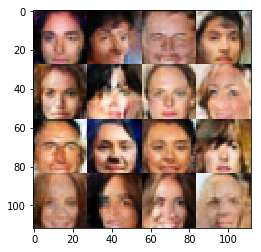

Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.3361
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.7726
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.1534


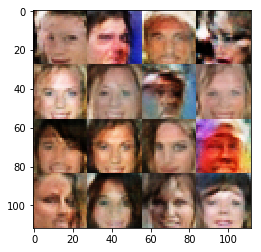

Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 0.9737
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 0.8068


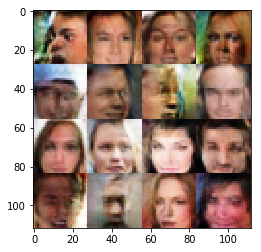

Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 0.8780
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 1.6559
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 2.0015
Epoch 1/2... Discriminator Loss: 1.2299... Generator Loss: 0.9242


In [28]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.